# Digital Analytics, Causal Knowledge Acquisition and Reasoning (DACKAR)

DACKAR is a software product designed to analyze equipment reliability data and provide system engineers with insights into anomalous behaviors or degradation trends as well as the possible causes behind, and to predict their direct consequences.

https://github.com/idaholab/DACKAR

https://idaholab.github.io/DACKAR/


![kg_slide_1.png](./images/kg_slide_1.png)

![use_case_slide_1.png](./images/use_case_slide_1.png)

![use_case_slide_2.png](./images/use_case_slide_2.png)

![use_case_slide_3.png](./images/use_case_slide_3.png)

## Demo of knowledge graph construction
This notebook is intended to show the steps required to construct the KG that include
- MBSE representation of the considered system
- Anomalies detected from numeric data
- Textual elements processed by TLP methods 

![kg_1.png](./images/kg_1.png)

This notebook requires that:
* Neo4j desktop is installed in your machine
* A neo4j project is initialized with the corresponding Graph DBMS such that the bolt port is available
* the csv files are located in the corresponding folder

### Steps to communicate with Neo4j 

1. Set import folder path for neo4j, this folder is used to store csv files (default is import folder)

2. Start neo4j desktop DBMS, set password if needed, this password will be used in Python driver to connect to DBMS database 
![neo4j.png](./images/neo4j.png)
3. Once connection is established, python functions can be used to communicate with Neo4j

### Set import folder path for neo4j and create python to neo4j driver

In [1]:
import os, sys
# Settings #
cwd = os.getcwd()
frameworkDir = os.path.abspath(os.path.join(cwd, os.pardir, 'src'))
sys.path.append(frameworkDir)
#######################
# Internal Modules #
from dackar.knowledge_graph.py2neo import Py2Neo
from dackar.knowledge_graph.graph_utils import set_neo4j_import_folder

# Change import folder to user specific location
config_file_path = "/Users/wangc/Library/Application Support/Neo4j Desktop/Application/relate-data/dbmss/dbms-28cea4a5-ad08-4fed-94a1-70d44e297586/conf/neo4j.conf"
import_folder_path = "/Users/wangc/projects/DACKAR/examples/KG_demo/"
set_neo4j_import_folder(config_file_path, import_folder_path)
# print(f"Neo4j import folder set to: {import_folder_path}")

# Create python to neo4j driver
uri = "neo4j://localhost:7687" # for a cluster
pwd = "123456789" # user need to provide the DBMS database password

py2neo = Py2Neo(uri=uri, user='neo4j', pwd=pwd)

### Load MBSE nodes and edges via functions

#### Load MBSE model node data

In [2]:
py2neo.reset()
file_path = './test_nodes.csv'
label = 'MBSE'
attribute = {'nodeId':'nodeId', 'label':'label', 'ID':'ID', 'type':'type'}
py2neo.load_csv_for_nodes(file_path, label, attribute)

#### Load MBSE model relationship data

In [3]:
file_path = 'test_edges.csv'
l1='MBSE'
p1={'nodeId':'sourceNodeId'}
l2='MBSE'
p2 ={'nodeId':'targetNodeId'}
lr = 'MBSE_link'
pr = {'prop':'type'}
py2neo.load_csv_for_relations(file_path, l1, p1, l2, p2, lr, pr)

### Load monitoring data

In [4]:
file_path = 'test_monit_vars.csv'
label = 'monitor_var'
attribute = {'nodeId':'varID'}
py2neo.load_csv_for_nodes(file_path, label, attribute)

### Load monitoring relationship data and link to MBSE model data

In [5]:
file_path = 'test_monit_vars.csv'
l1='monitor_var'
p1={'nodeId':'varID'}
l2='MBSE'
p2 ={'nodeId':'MBSE_ID'}
lr = 'monitoring'
pr = None
py2neo.load_csv_for_relations(file_path, l1, p1, l2, p2, lr, pr)

### Load anomaly detection data

In [6]:
file_path = 'test_AD.csv'
label = 'anomaly_detect'
attribute = {'nodeId':'AD_ID', 'type':'type'}
py2neo.load_csv_for_nodes(file_path, label, attribute)

### Load anomaly detection relation data and link to monitoring data

In [7]:
file_path = 'test_AD.csv'
l1='anomaly_detect'
p1={'nodeId':'AD_ID'}
l2='monitor_var'
p2 ={'nodeId':'var_ID'}
lr = 'input_from'
pr = None
py2neo.load_csv_for_relations(file_path, l1, p1, l2, p2, lr, pr)

### Load anomalies

In [8]:
file_path = 'test_anomalies.csv'
label = 'anomaly'
attribute = {'nodeId':'anom_ID', 'time_initial':'t_in', 'time_final':'t_fin'}
py2neo.load_csv_for_nodes(file_path, label, attribute)

### Load anomalies relation data and link to anomaly detection method

In [9]:
file_path = 'test_anomalies.csv'
l1='anomaly'
p1={'nodeId':'anom_ID'}
l2='anomaly_detect'
p2 ={'nodeId':'AD_ID'}
lr = 'detected_by'
pr = None
py2neo.load_csv_for_relations(file_path, l1, p1, l2, p2, lr, pr)
py2neo.close()

## Demo of time series anomaly detection

![anomaly_types_2.png](./images/anomaly_types_2.png)

ref: Lai, Kwei-Herng, et al. "Revisiting time series outlier detection: Definitions and benchmarks." Thirty-fifth conference on neural information processing systems datasets and benchmarks track (round 1). 2021.

### Load anomaly module and test data

In [10]:
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
import pandas as pd
import os
from dackar.anomalies.MatrixProfile import MatrixProfile

cwd = os.getcwd()
data_path = os.path.abspath(os.path.join(cwd, os.pardir, 'data'))
taxi_data_file = os.path.abspath(os.path.join(data_path, 'nyc_taxi_passengers.csv'))
steam_gen_data_file = os.path.abspath(os.path.join(data_path, 'Steamgen.csv'))

# Set the time window
m = 48

### Load NY taxi data and calculate the matrix profiles 

#### Simple example
![ny_taxi_data.png](./images/ny_taxi_data.png)
![ny_taxi_mp.png](./images/ny_taxi_mp.png)
Link: https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html 

### Real application for nuclear system

![image-3.png](./images/anomaly_pump.png)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


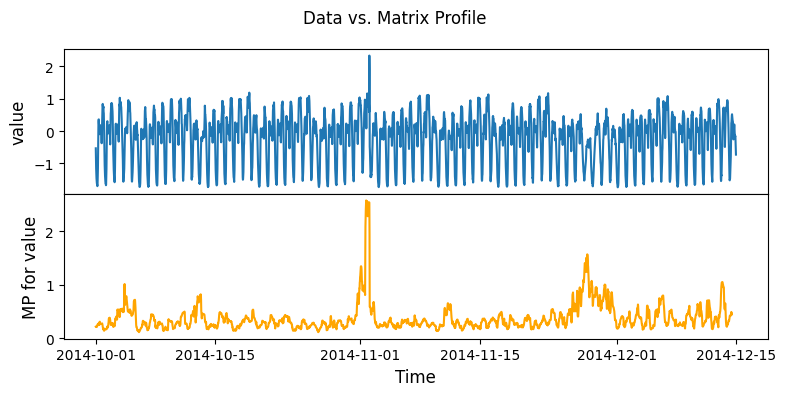

In [11]:
taxi_df = pd.read_csv(taxi_data_file, index_col='timestamp')
taxi_df['value'] = taxi_df['value'].astype(np.float64)
taxi_df.index = pd.to_datetime(taxi_df.index, errors='ignore')
mpObj = MatrixProfile(m=24, normalize='robust', method='normal')
mpObj.fit(taxi_df)
fig = mpObj.plot()

### Load steam generator data and compute the matrix profile for anomaly detection

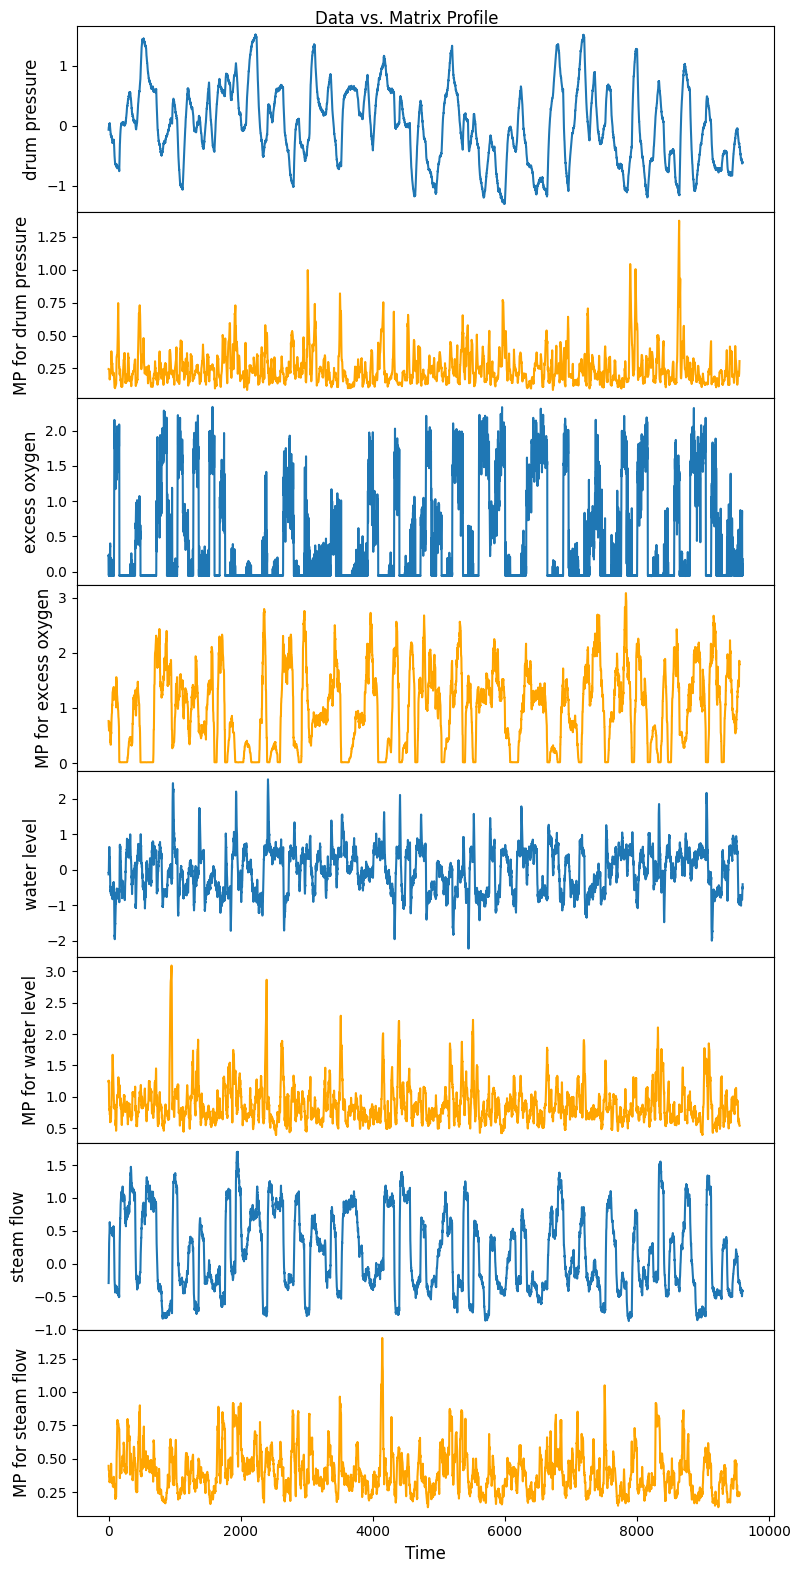

In [12]:
steam_df = pd.read_csv(steam_gen_data_file)
mpObj = MatrixProfile(m=48, normalize='robust', method='normal')
mpObj.fit(steam_df)
fig = mpObj.plot()

## Multi-dimensional anomaly detection: identify best K out of N anomalies

### Simple example:

Ref: Tafazoli, Sadaf, and Eamonn Keogh. "Matrix profile xxviii: Discovering multi-dimensional time series anomalies with k of n anomaly detection." Proceedings of the 2023 SIAM International Conference on Data Mining (SDM). Society for Industrial and Applied Mathematics, 2023.

![kdp_1.png](./images/kdp_1.png)

![kdp_2.png](./images/kdp_2.png)

### Real application for nuclear system
![kdp_3.png](./images/kdp_3.png)

### Simple example for demonstration

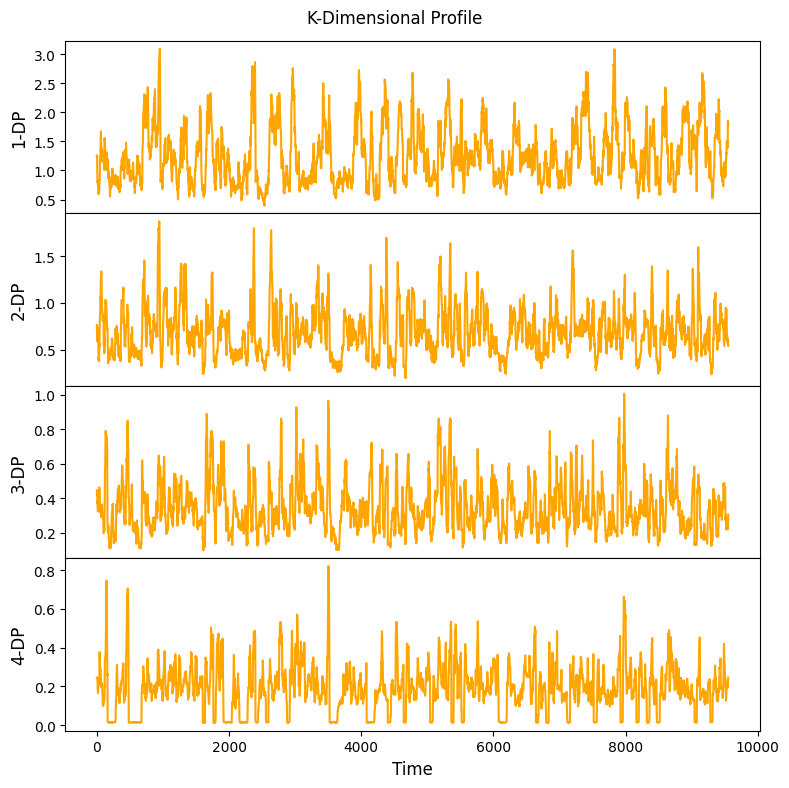

In [13]:
mpObj = MatrixProfile(m, normalize='robust', method='normal', kdp=True)
mpObj.fit(steam_df)
fig = mpObj.plot_kdp()

## Technical Language Processing or Natural Language Processing

- Information Extraction
  
  <img src="./images/info_extraction.png" width="800" height="300">

- Cause-Effect Identification
  
  <img src="./images/cause_effect.png" width="800" height="300">



#### NLP Pipelines

- Tokenization, Part-of-Speech (POS), Dependency Parsing, Lemmatization, Sentence Boundary Detection, Named Entity Recognition, Similarity, Entity Linking etc. 

![nlp_pipelines.png](./images/nlp_pipelines.png)

In [14]:
import spacy
nlp = spacy.load("en_core_web_lg")
nlp.add_pipe("merge_entities")
doc = nlp("A leak was noticed from the RCP pump.")
spacy.displacy.render(doc, style="dep")

#### Sentence Similarity with Disambiguation 

![image.png](./images/similarity.png)

In [15]:
from dackar.similarity import synsetUtils as SU
from dackar.similarity import simUtils

sents = ['A leak was noticed from the RCP pump',
'The shaft vibration appears to be causing the motor to vibrate']

sentSynsets = simUtils.convertSentsToSynsetsWithDisambiguation(sents)
similarity = SU.synsetListSimilarity(sentSynsets[0], sentSynsets[1], delta=.8)
print('Similarity: ',similarity)

sents = ['Rupture of pump bearings caused shaft degradation',
         'The shaft degradation was caused by the rupture of pump bearings']
sentSynsets = simUtils.convertSentsToSynsetsWithDisambiguation(sents)
similarity = SU.synsetListSimilarity(sentSynsets[0], sentSynsets[1], delta=.8)
print('Similarity: ', similarity)

Warming up PyWSD (takes ~10 secs)... 

Similarity:  0.09147345140096318
Similarity:  0.7901826659113357


took 2.000033140182495 secs.


#### Named Entity Recognition

In [16]:
from dackar.pipelines.TemporalEntity import Temporal
from dackar.pipelines.UnitEntity import UnitEntity
from dackar.utils.nlp.nlp_utils import resetPipeline

txt = """The event is scheduled for 25th August 2023. We also have a meeting on 10 September and
        another one on the twelfth of October and a final one on January fourth. Yesterday afternoon,
        before 2022, after 12/2024."""
nlp = resetPipeline(nlp, pipes=['Temporal'])
doc = nlp(txt)
spacy.displacy.render(doc, style="ent")

In [17]:
nlp = resetPipeline(nlp, pipes=['unit_entity'])
txt = """I want a gallon of beer.
              The LHC smashes proton beams at 12.8-13.0 TeV,
              The LHC smashes proton beams at 12.9±0.1 TeV.
              Sound travels at 0.34 km/s,
              I want 2 liters of wine.
              I spent 20 pounds on this!
              The average density of the Earth is about 5.5x10-3 kg/cm³,
              Gimme 10e9 GW now!"""
nlp = resetPipeline(nlp, pipes=['unit_entity'])
doc = nlp(txt)
spacy.displacy.render(doc, style="ent")